In [1]:
%tensorflow_version 1.x
import keras
keras.__version__

TensorFlow 1.x selected.


Using TensorFlow backend.


'2.3.1'

**데이터 준비하기**

In [0]:
import os

In [3]:
#Google drive에 옮긴 jena climate 데이터셋을 불러옵니다
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#데이터셋을 저장할 디렉토리를 지정합니다.
data_dir = ('/content/drive/My Drive/')

In [0]:
#data_dir을 'jena_climate_2009_2016.csv와 합쳐서 경로를 만듭니다.
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [6]:
#데이터를 살펴봅니다.
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
#데이터프레임으로 자료를 나타내봅니다.
!pip install -q sklearn

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [8]:
dataframe = pd.read_csv(fname)
dataframe.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Date Time을 보면, 10분마다 데이터가 기록된 것을 알수있습니다.
즉, 한시간에 6개의 관측값이 존재하고, 하루에는 24*6=144개의 온도 관측값이 존재합니다.

In [9]:
#line을 확인해서 데이터의 형태를확인합니다.
lines[:1]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']

In [0]:
#데이터를 numpy 배열로 변경합니다.
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))        #0으로 채워진 len(lines)행,len(header)-1열의 numpy array 공간을 만들어줍니다.
for i, line in enumerate(lines):                            #i는 몇번째 line인지 표시해줍니다.
    values = [float(x) for x in line.split(',')[1:]]        #line을','로 구분해서, 0번째(시간)를 제외하고 value로 저장해줍니다.
    float_data[i, :] = values                               #저장했던 float_data 공간에 value들을 채워줍니다.

In [11]:
#위 작업을 통해 데이터가 어떻게 정리되었는지 확인해봅니다.
float_data[:1]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02]])

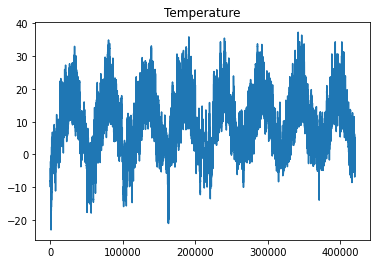

In [12]:
#시간에 따른 기온 그래프를 살펴봅니다.
from matplotlib import pyplot as plt

temperature = float_data[:, 1]  
plt.plot(range(len(temperature)), temperature)
plt.title('Temperature')
plt.show()

온도 데이터에 주기성이 있다는것을 확인할수있습니다.

**데이터 정규화하기**

처음 200000개의 자료를 평균을 빼주고, 표준편차를 나눠서 train data로 사용하려합니다.

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

**generator 함수 생성하기**

In [0]:
#(samples, targets)를 반환하는 함수를 정의합니다.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)                                            #데이터를 랜덤하게 샘플링해서 각 generator를 생성해주는 함수.

        samples = np.zeros((len(rows),                              #samples과 targets의 공간을 만들어줍니다. (=batch size)
                           lookback // step,                       #데이터의 갯수 차원 (한시간단위로 보고싶기때문에 step으로 나눠준 값을 사용합니다.)
                           data.shape[-1]))                        # (14개의 날씨정보차원)
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):                             
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets                                      #반복해서 데이터를 샘플링해 채워넣습니다.

**generator 함수 이용하여 train_gen, val_gen, test_gen 생성하기**

In [0]:
lookback = 1440     #10일 전 데이터
step = 6            #1시간마다 데이터
delay = 144         #하루가 지난 데이터
batch_size = 128    #몇개씩 데이터를 훈련할건지 설정해줍니다.

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)             #0~200000까지의 데이터를 train_gen로 사용합니다.
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)               #200001~300000까지의 데이터를 val_gen으로 사용합니다.
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)              #300001~끝까지의 데이터를 test_gen으로 사용합니다.

val_steps = (300000 - 200001 - lookback) // batch_size   

test_steps = (len(float_data) - 300001 - lookback) // batch_size

**1D Convnet을 사용하여 모델세우기**

In [0]:
from keras.models import Sequential
from keras import layers
from keras import Input
from keras.optimizers import RMSprop

In [17]:
c_model=Sequential()
c_model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
c_model.add(layers.MaxPooling1D(3))
c_model.add(layers.Conv1D(32, 5, activation='relu'))
c_model.add(layers.MaxPooling1D(3))
c_model.add(layers.Conv1D(32, 5, activation='relu'))
c_model.add(layers.GlobalMaxPooling1D())
c_model.add(layers.Dense(1))                          #회귀문제이므로 마지막 Dense층에 activation은 생략합니다.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
c_model.compile(optimizer=RMSprop(), loss='mae')

In [19]:
c_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

**모델의 층 그래프 그려보기**

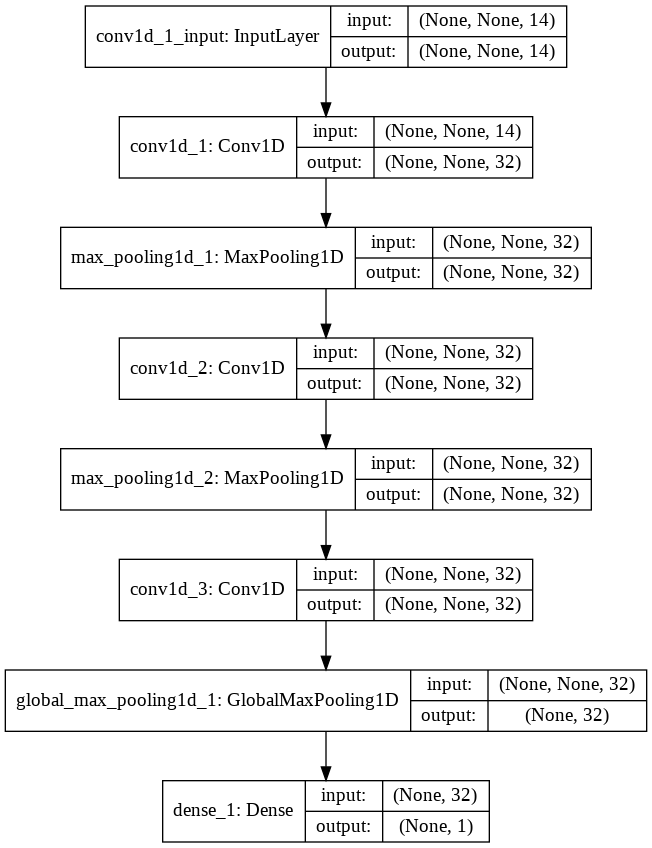

In [20]:
from keras.utils import plot_model
plot_model(c_model, show_shapes=True, show_layer_names=True, to_file='model.png')

**모델 훈련시키기**

In [43]:
history = c_model.fit_generator(train_gen,
                              steps_per_epoch=100,     #한 epoch당 100번의 step을 진행합니다.
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 23s 226ms/step - loss: 0.2458 - val_loss: 0.5693
Epoch 2/20
100/100 [==============================] - 22s 219ms/step - loss: 0.2471 - val_loss: 0.3332
Epoch 3/20
100/100 [==============================] - 22s 219ms/step - loss: 0.2452 - val_loss: 0.6335
Epoch 4/20
100/100 [==============================] - 22s 219ms/step - loss: 0.2456 - val_loss: 0.5618
Epoch 5/20
100/100 [==============================] - 22s 220ms/step - loss: 0.2438 - val_loss: 0.4813
Epoch 6/20
100/100 [==============================] - 22s 224ms/step - loss: 0.2425 - val_loss: 0.6595
Epoch 7/20
100/100 [==============================] - 22s 221ms/step - loss: 0.2462 - val_loss: 0.6184
Epoch 8/20
100/100 [==============================] - 22s 220ms/step - loss: 0.2449 - val_loss: 0.6460
Epoch 9/20
100/100 [==============================] - 22s 221ms/step - loss: 0.2406 - val_loss: 0.6809
Epoch 10/20
100/100 [==============================] - 22s 219ms/step - l

**손실 그래프 그려보기**

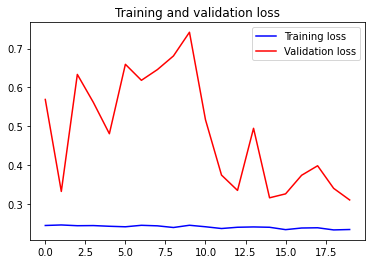

In [44]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Overfitting이 있는것을 확인할수있습니다.
Training loss는 점점 감소하는데, Validation loss는 증가 감소를 반복합니다.

Overfitting을 방지하고 성능을 더 향상시키기위해 LSTM층으로 다른 모델을 구성합니다.

**LSTM 모델층쌓기**

In [0]:
from keras.layers import LSTM

In [0]:
l_model= Sequential()
l_model.add(layers.LSTM(32, return_sequences=True, input_shape=(None, float_data.shape[-1])))
l_model.add(layers.LSTM(16))
l_model.add(layers.Dense(1))        

EarlyStopping callback을 사용해 2 epoch동안 손실이 더이상 좋아지지않으면 훈련을 중지하도록합니다.

In [39]:
import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='l_model.jena',
        monitor='val_loss',
        save_best_only=True,
    )
]                                                         #Training동안 가장 좋은모델을 저장하기위해, 성능향상이 멈추면(loss를 모니터링해서) 훈련이 멈추도록합니다.
l_model.compile(optimizer=RMSprop(), loss='mae')
history=l_model.fit_generator(train_gen,
                              steps_per_epoch=100,        
                              epochs=20,
                              callbacks=callbacks_list,
                              validation_data=val_gen,
                              validation_steps=val_steps)    #steps_per_epoch=500으로 할 경우 너무 느려서 100으로 수정한후 수행합니다.

Epoch 1/20
100/100 [==============================] - 86s 862ms/step - loss: 0.2407 - val_loss: 0.4222
Epoch 2/20
100/100 [==============================] - 86s 864ms/step - loss: 0.2376 - val_loss: 0.5006
Epoch 3/20
100/100 [==============================] - 83s 825ms/step - loss: 0.2301 - val_loss: 0.2811
Epoch 4/20
100/100 [==============================] - 87s 865ms/step - loss: 0.2310 - val_loss: 0.3923


성능향상이 4 Epoch에서 멈추는 것을 확인할수있습니다.

**모델 층 그래프 그려보기**

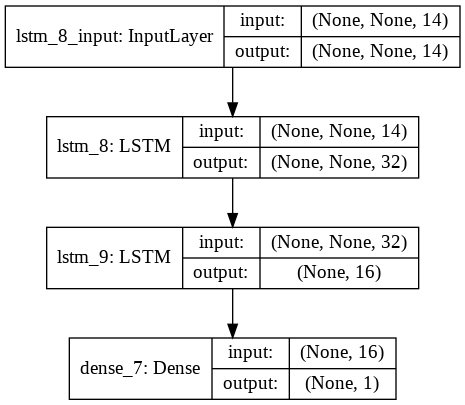

In [40]:
from keras.utils import plot_model
plot_model(l_model, show_shapes=True, show_layer_names=True, to_file='model.png')

<Figure size 432x288 with 0 Axes>

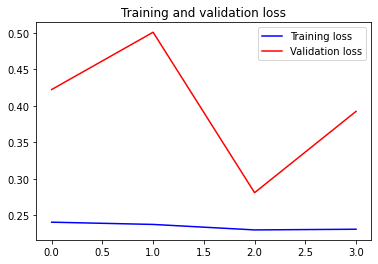

In [42]:
#그래프를 초기화한후, 손실그래프를 다시 그려봅니다.
plt.clf()           
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Training loss는 계속 감소합니다.
하지만 Validation loss는 불안정하다는것을 볼 수 있습니다.
그래도 Conv1D를 사용해 모델층을 쌓은 네트워크보다는 LSTM의 네트워크가 성능이 좀 더 높다는것을 확인할수있습니다.